In [240]:
import pandas as pd
import numpy as np
import xlrd
import seaborn as sns
import copy
import sklearn
from matplotlib import pyplot as plt
from scipy.stats import shapiro
from scipy.stats import kstest
from sklearn.cluster import SpectralClustering
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

# read Excel file into a DataFrame
df = pd.read_excel(r'CTG.xls', 'Raw Data', header = 0)

pd.set_option("display.max_rows", None, "display.max_columns", None)
df.to_csv (r'CTG.csv', index = True, header=True)

# DROP UNUSED COLUMNS
list_columns_to_remove = ['b','e','A','B','C','D','E','LBE','AD','DE','LD','FS','SUSP','FileName','Date','SegFile']
df = df.drop(list_columns_to_remove, axis=1)

# add an 'id' column to use it as an index
df["id"] = df.index + 1

In [241]:
# DROP ROWS CONTAINED NAN
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

# Find out if any null values exists in our dataset
print ('The dataset contains null values: ', df.isna().any().sum())


The dataset contains null values:  0


In [242]:
# Check for duplicate values and delete them
print ("From the dataset removed duplicate values: ", df.drop_duplicates(inplace=True))

# Check for missing data
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

From the dataset removed duplicate values:  None
LB - 0%
AC - 0%
FM - 0%
UC - 0%
ASTV - 0%
MSTV - 0%
ALTV - 0%
MLTV - 0%
DL - 0%
DS - 0%
DP - 0%
DR - 0%
Width - 0%
Min - 0%
Max - 0%
Nmax - 0%
Nzeros - 0%
Mode - 0%
Mean - 0%
Median - 0%
Variance - 0%
Tendency - 0%
CLASS - 0%
NSP - 0%
id - 0%


In [243]:
# uninformative features - tοo many rows with same values
num_rows = len(df.index)
low_information_cols = [] #

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

DS: 99.67074%
0.0    2119
1.0       7
Name: DS, dtype: int64

DR: 100.00000%
0.0    2126
Name: DR, dtype: int64



C:\Users\user\anaconda3\envs\hello-tf\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared


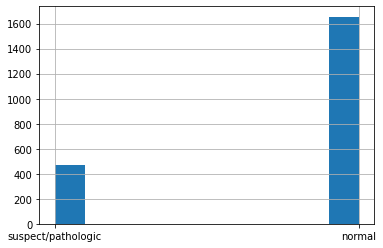

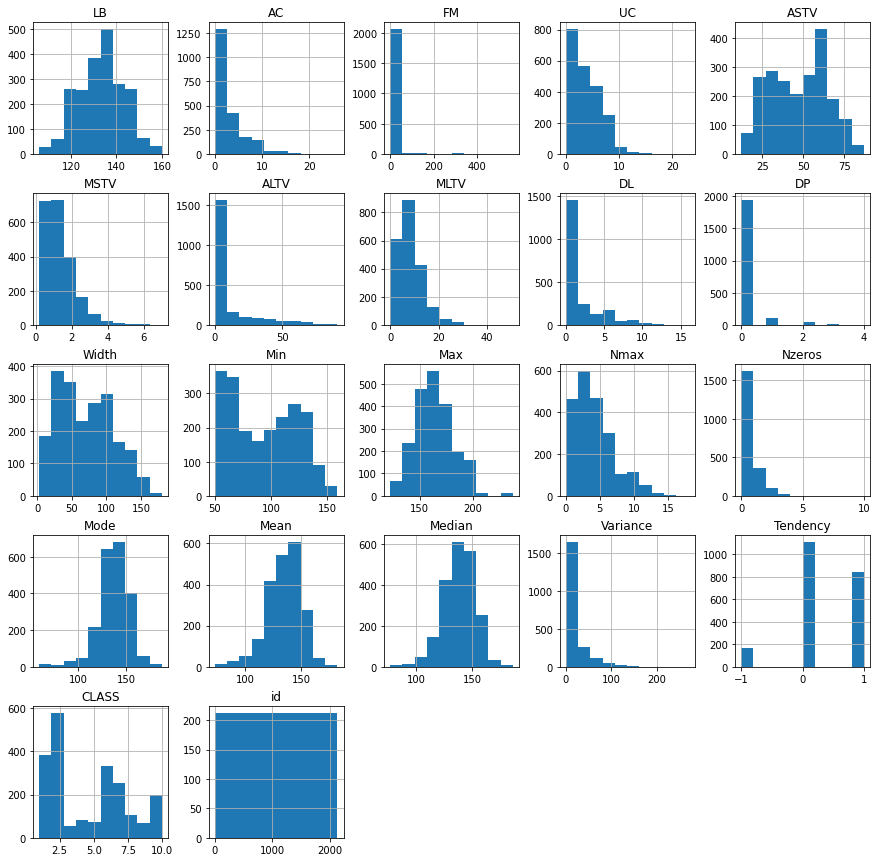

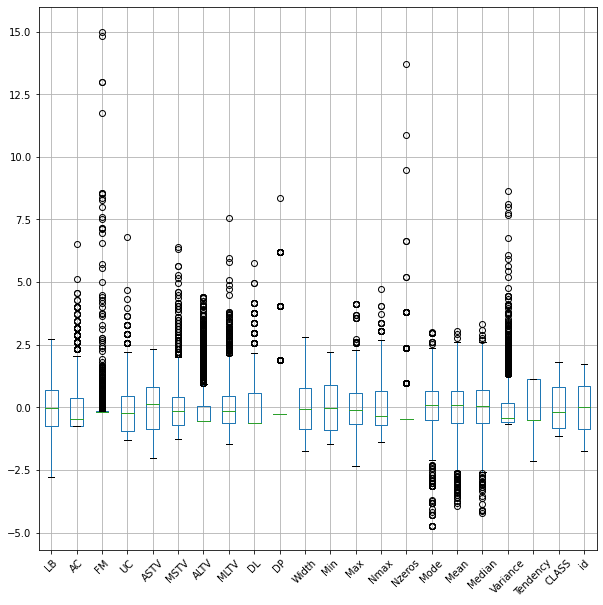

In [244]:
# delete these features (columns) - we will not use them in our model
del df['DS']
del df['DR']

# transformation - binarize the NSP class
df['newNSP'] = np.where(df.NSP == 1, 1, 0)  # recodes normal to 1 and everything else to 0

# Plot histogram 
fig, ax = plt.subplots(1,1)
df.newNSP.hist()
class_names = ['normal', 'suspect/pathologic']
ax.set_xticks([1,0])
ax.set_xticklabels(class_names)

# Histogram for all features
df_X = df.drop(columns=['NSP', 'newNSP'])
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
df_X.hist(ax=ax)
plt.show()

# Boxplots for feature distributions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df_scale_X = pd.DataFrame(sklearn.preprocessing.scale(df_X), columns=df_X.columns)
df_scale_X.boxplot(ax=ax, rot=45)
plt.show()


In [25]:
# VISUALIZE FEATURES TO FIND CORRELATIONS BETWEEN THEM
import plotly.express as px
fig = px.scatter_matrix(df.drop("id",axis=1),width=3000, height=3600)
fig.show()

In [245]:
print("-------------------- Kolmogorov-Smirnov Test --------------------")
# check for normal/gaussian dristribution using Kolmogorov-Smirnov Test
for i in df.columns:
    print(f'{i}: {"Not Gaussian" if kstest(df[i].values,"norm")[1]<0.05 else "Gaussian"}  {kstest(df[i].values,"norm")}')

print("-------------------- Shapiro-Wilk Test --------------------")
# check for normal/gaussian distribution using Shapiro-Wilk Test
for i in df.columns:
    print(f'{i}: {"Not Gaussian" if shapiro(df[i])[1]<0.05 else "Gaussian"}  {shapiro(df[i])}')

-------------------- Kolmogorov-Smirnov Test --------------------
LB: Not Gaussian  KstestResult(statistic=1.0, pvalue=0.0)
AC: Not Gaussian  KstestResult(statistic=0.5, pvalue=0.0)
FM: Not Gaussian  KstestResult(statistic=0.5, pvalue=0.0)
UC: Not Gaussian  KstestResult(statistic=0.7091407429342291, pvalue=0.0)
ASTV: Not Gaussian  KstestResult(statistic=1.0, pvalue=0.0)
MSTV: Not Gaussian  KstestResult(statistic=0.5958041785389055, pvalue=0.0)
ALTV: Not Gaussian  KstestResult(statistic=0.5, pvalue=0.0)
MLTV: Not Gaussian  KstestResult(statistic=0.8605701028336352, pvalue=0.0)
DL: Not Gaussian  KstestResult(statistic=0.5, pvalue=0.0)
DP: Not Gaussian  KstestResult(statistic=0.5, pvalue=0.0)
Width: Not Gaussian  KstestResult(statistic=0.9990589795760857, pvalue=0.0)
Min: Not Gaussian  KstestResult(statistic=1.0, pvalue=0.0)
Max: Not Gaussian  KstestResult(statistic=1.0, pvalue=0.0)
Nmax: Not Gaussian  KstestResult(statistic=0.7910154892482231, pvalue=0.0)
Nzeros: Not Gaussian  KstestResu

In [246]:
# Select the columns - features for scaling
cols = [col for col in df.columns if col not in ['CLASS', 'NSP','newNSP', 'id']]
df2 = df[cols]

# copy the dataframe
df_norm = df.copy()

In [15]:
# apply maximum absolute scaling
for column in df2:
    df[column] = df_norm[column]  / df_norm[column].abs().max()

In [247]:
# apply min-max scaling
for column in df2:
    df[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())

In [8]:
# apply robust scaling
for column in df2:
    df[column] = (df_norm[column] - df_norm[column].median())  / (df_norm[column].quantile(0.75) - df_norm[column].quantile(0.25))

In [248]:
# print values
df

LB        AC        FM        UC      ASTV      MSTV      ALTV  \
1     0.259259  0.000000  0.000000  0.000000  0.813333  0.044118  0.472527   
2     0.481481  0.153846  0.000000  0.173913  0.066667  0.279412  0.000000   
3     0.500000  0.076923  0.000000  0.217391  0.053333  0.279412  0.000000   
4     0.518519  0.076923  0.000000  0.260870  0.053333  0.323529  0.000000   
5     0.481481  0.153846  0.000000  0.217391  0.053333  0.323529  0.000000   
6     0.518519  0.038462  0.000000  0.434783  0.186667  0.838235  0.000000   
7     0.518519  0.038462  0.000000  0.391304  0.226667  0.897059  0.000000   
8     0.296296  0.000000  0.000000  0.000000  0.946667  0.044118  0.065934   
9     0.296296  0.000000  0.000000  0.043478  0.960000  0.044118  0.054945   
10    0.296296  0.000000  0.000000  0.130435  0.986667  0.014706  0.065934   
11    0.833333  0.000000  0.000000  0.043478  0.693333  0.250000  0.098901   
12    0.814815  0.000000  0.000000  0.043478  0.693333  0.264706  0.087912   
13    0.462963  0.153846  0.101064  0.260870  0.213333  0.176471  0.000000   
14    0.462963  0.230769  0.260638  0.173913  0.213333  0.191176  0.000000   
15    0.444444  0.269231  0.867021  0.217391  0.120000  0.308824  0.000000   
16    0.444444  0.153846  0.484043  0.130435  0.093333  0.308824  0.000000   
17    0.444444  0.153846  0.514184  0.130435  0.160000  0.279412  0.000000   
18    0.462963  0.038462  0.445035  0.086957  0.080000  0.323529  0.000000   
19    0.444444  0.076923  0.562057  0.173913  0.146667  0.250000  0.000000   
20    0.444444  0.230769  0.987589  0.260870  0.226667  0.220588  0.000000   
21    0.425926  0.000000  0.539007  0.173913  0.240000  0.279412  0.000000   
22    0.407407  0.115385  0.482270  0.086957  0.186667  0.220588  0.000000   
23    0.407407  0.000000  0.388298  0.086957  0.293333  0.338235  0.000000   
24    0.407407  0.000000  0.000000  0.000000  0.906667  0.044118  0.000000   
25    0.407407  0.000000  0.000000  0.086957  0.986667  0.014706  0.868132   
26    0.333333  0.000000  0.000000  0.000000  0.986667  0.014706  0.791209   
27    0.333333  0.000000  0.000000  0.000000  0.986667  0.029412  0.153846   
28    0.333333  0.000000  0.000000  0.000000  1.000000  0.000000  0.780220   
29    0.481481  0.000000  0.287234  0.043478  0.226667  0.617647  0.000000   
30    0.481481  0.000000  0.115248  0.000000  0.186667  0.852941  0.000000   
31    0.481481  0.000000  0.228723  0.086957  0.186667  0.632353  0.000000   
32    0.481481  0.000000  0.140071  0.130435  0.133333  0.985294  0.000000   
33    0.481481  0.000000  0.113475  0.043478  0.226667  0.397059  0.000000   
34    0.259259  0.346154  0.218085  0.043478  0.213333  0.470588  0.000000   
35    0.259259  0.230769  0.099291  0.043478  0.213333  0.441176  0.000000   
36    0.259259  0.192308  0.159574  0.260870  0.200000  0.514706  0.000000   
37    0.166667  0.230769  0.168440  0.260870  0.146667  0.470588  0.000000   
38    0.148148  0.115385  0.000000  0.130435  0.160000  0.441176  0.000000   
39    0.166667  0.192308  0.092199  0.130435  0.133333  0.500000  0.000000   
40    0.166667  0.346154  0.095745  0.217391  0.200000  0.308824  0.000000   
41    0.148148  0.384615  0.122340  0.347826  0.213333  0.294118  0.000000   
42    0.148148  0.153846  0.054965  0.260870  0.200000  0.323529  0.000000   
43    0.185185  0.038462  0.044326  0.130435  0.373333  0.205882  0.010989   
44    0.185185  0.115385  0.015957  0.173913  0.373333  0.235294  0.010989   
45    0.296296  0.000000  0.024823  0.086957  0.133333  0.617647  0.000000   
46    0.296296  0.000000  0.024823  0.086957  0.120000  0.661765  0.000000   
47    0.296296  0.000000  0.005319  0.217391  0.066667  0.691176  0.000000   
48    0.296296  0.076923  0.005319  0.217391  0.106667  0.705882  0.000000   
49    0.296296  0.076923  0.007092  0.173913  0.133333  1.000000  0.000000   
50    0.962963  0.230769  0.000000  0.391304  0.200000  0.220588  0.000000   
51    0.962963  0.153846  0.000000

In [9]:
# we delete these columns cause they contain Nan and inf values (after robust scaling)
del df['DP']
del df['Nzeros']

In [249]:
# SELECT THE COLUMNS/FEATURES TO USE FOR CLUSTERING
cols = [col for col in df.columns if col in ['Width', 'Min','ALTV','Median','Mean']]
df2 = df[cols]
df2.to_numpy()

array([[0.47252747, 0.34463277, 0.11009174, 0.58715596, 0.40366972],
       [0.        , 0.71751412, 0.16513761, 0.57798165, 0.57798165],
       [0.        , 0.71751412, 0.16513761, 0.56880734, 0.55963303],
       ...,
       [0.21978022, 0.36158192, 0.48623853, 0.68807339, 0.68807339],
       [0.2967033 , 0.3559322 , 0.48623853, 0.67889908, 0.67889908],
       [0.3956044 , 0.22033898, 0.6146789 , 0.64220183, 0.62385321]])

In [172]:
# SPECTRAL CLUSTERING

spectral_cluster_model= SpectralClustering(
    n_clusters=2, 
    random_state=25, 
    n_neighbors=5, 
    affinity='nearest_neighbors'
)

label = spectral_cluster_model.fit_predict(df2)

df['spectral-cluster-label'] = label.tolist()
# plot
# fig, ax = plt.subplots()
# sns.scatterplot(x='LB', y='FM', data=df, hue='spectral-cluster-label', ax=ax)
# ax.set(title='Spectral Clustering')

C:\Users\user\anaconda3\envs\hello-tf\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



In [162]:
# BIRCH CLUSTERING

bclust=Birch(branching_factor=200, n_clusters = 2, threshold=.5).fit(df2)
print(bclust)

label = bclust.predict(df2)
df['Birch-cluster-label'] = label.tolist()

Birch(branching_factor=200, n_clusters=2)


In [169]:
# K-MEANS CLUSTERING

kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init=50,
    max_iter=100,
    random_state=25
)

kmeans.fit(df2)
label = kmeans.fit_predict(df2)
df['k-means-cluster-label'] = label.tolist()

In [309]:
# AGGLOMERATIVE - WARD HIERARCHICAL CLUSTERING

cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')  
label = cluster.fit_predict(df3)
df['Agg-Hier-clust-label'] = label.tolist()

In [229]:
# DBSCAN CLUSTERING ALGORITHM
DBSCAN_cluster = DBSCAN(eps=10, min_samples=35).fit(df3)

label = DBSCAN_cluster.labels_
df['dbscan-cluster-label'] = label.tolist()

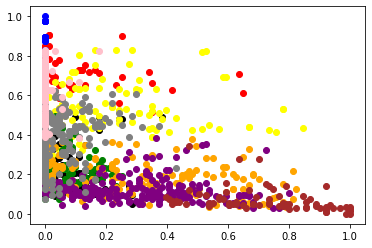

In [310]:
# plot the clusters - num of clusters 2 or 10
label_0 = df2[label == 0]
label_1 = df2[label == 1]
label_2 = df2[label == 2]
label_3 = df2[label == 3]
label_4 = df2[label == 4]
label_5 = df2[label == 5]
label_6 = df2[label == 6]
label_7 = df2[label == 7]
label_8 = df2[label == 8]
label_9 = df2[label == 9]

plt.scatter(label_0.iloc[:,0].values, label_0.iloc[:,1].values, color = 'red')
plt.scatter(label_1.iloc[:,0].values, label_1.iloc[:,1].values, color = 'black')
plt.scatter(label_2.iloc[:,0].values, label_2.iloc[:,1].values, color = 'blue')
plt.scatter(label_3.iloc[:,0].values, label_3.iloc[:,1].values, color = 'yellow')
plt.scatter(label_4.iloc[:,0].values, label_4.iloc[:,1].values, color = 'green')
plt.scatter(label_5.iloc[:,0].values, label_5.iloc[:,1].values, color = 'orange')
plt.scatter(label_6.iloc[:,0].values, label_6.iloc[:,1].values, color = 'purple')
plt.scatter(label_7.iloc[:,0].values, label_7.iloc[:,1].values, color = 'grey')
plt.scatter(label_8.iloc[:,0].values, label_8.iloc[:,1].values, color = 'pink')
plt.scatter(label_9.iloc[:,0].values, label_9.iloc[:,1].values, color = 'brown')
plt.show()

In [379]:
np.set_printoptions(threshold=2126)
# print(label)

In [320]:
# convert labels to list for evaluation - CLASS
labels_true = list(df["CLASS"])
labels_pred = label.tolist()

In [321]:
# Rand index
print(metrics.rand_score(labels_true, labels_pred))
print(metrics.adjusted_rand_score(labels_true, labels_pred))

0.7823044657185546
0.08911454230663869


In [322]:
# Mutual Information based scores
print(metrics.adjusted_mutual_info_score(labels_true, labels_pred))
print(metrics.normalized_mutual_info_score(labels_true, labels_pred))
print(metrics.mutual_info_score(labels_true, labels_pred))

0.22481207089475044
0.2320093891512496
0.4905788487373758


In [323]:
# Homogeneity, completeness and V-measure
print (metrics.homogeneity_score(labels_true, labels_pred))
print (metrics.completeness_score(labels_true, labels_pred))
print (metrics.v_measure_score(labels_true, labels_pred, beta= 1))

0.24293480711208346
0.22202436866768593
0.23200938915124958


In [324]:
# Fowlkes-Mallows scores
metrics.fowlkes_mallows_score(labels_true, labels_pred)

0.21441917786418316

In [180]:
# convert labels to list for evaluation - newNSP
labels_true = list(df["newNSP"])
labels_pred = label.tolist()

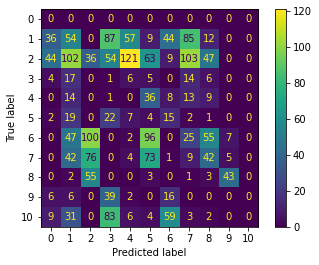

In [325]:
# Confusion Matrix
cm = confusion_matrix(labels_true, labels_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [258]:
# extract only the features-attributes of the dataset to apply for PCA
cols = [col for col in df.columns if col not in ['id','CLASS', 'NSP','newNSP', 'spectral-cluster-label', 'k-means-cluster-label', 'Birch-cluster-label', 'Agg-Hier-clust-label', 'dbscan-cluster-label']]
df3 = df[cols]
df3

LB        AC        FM        UC      ASTV      MSTV      ALTV  \
1     0.259259  0.000000  0.000000  0.000000  0.813333  0.044118  0.472527   
2     0.481481  0.153846  0.000000  0.173913  0.066667  0.279412  0.000000   
3     0.500000  0.076923  0.000000  0.217391  0.053333  0.279412  0.000000   
4     0.518519  0.076923  0.000000  0.260870  0.053333  0.323529  0.000000   
5     0.481481  0.153846  0.000000  0.217391  0.053333  0.323529  0.000000   
6     0.518519  0.038462  0.000000  0.434783  0.186667  0.838235  0.000000   
7     0.518519  0.038462  0.000000  0.391304  0.226667  0.897059  0.000000   
8     0.296296  0.000000  0.000000  0.000000  0.946667  0.044118  0.065934   
9     0.296296  0.000000  0.000000  0.043478  0.960000  0.044118  0.054945   
10    0.296296  0.000000  0.000000  0.130435  0.986667  0.014706  0.065934   
11    0.833333  0.000000  0.000000  0.043478  0.693333  0.250000  0.098901   
12    0.814815  0.000000  0.000000  0.043478  0.693333  0.264706  0.087912   
13    0.462963  0.153846  0.101064  0.260870  0.213333  0.176471  0.000000   
14    0.462963  0.230769  0.260638  0.173913  0.213333  0.191176  0.000000   
15    0.444444  0.269231  0.867021  0.217391  0.120000  0.308824  0.000000   
16    0.444444  0.153846  0.484043  0.130435  0.093333  0.308824  0.000000   
17    0.444444  0.153846  0.514184  0.130435  0.160000  0.279412  0.000000   
18    0.462963  0.038462  0.445035  0.086957  0.080000  0.323529  0.000000   
19    0.444444  0.076923  0.562057  0.173913  0.146667  0.250000  0.000000   
20    0.444444  0.230769  0.987589  0.260870  0.226667  0.220588  0.000000   
21    0.425926  0.000000  0.539007  0.173913  0.240000  0.279412  0.000000   
22    0.407407  0.115385  0.482270  0.086957  0.186667  0.220588  0.000000   
23    0.407407  0.000000  0.388298  0.086957  0.293333  0.338235  0.000000   
24    0.407407  0.000000  0.000000  0.000000  0.906667  0.044118  0.000000   
25    0.407407  0.000000  0.000000  0.086957  0.986667  0.014706  0.868132   
26    0.333333  0.000000  0.000000  0.000000  0.986667  0.014706  0.791209   
27    0.333333  0.000000  0.000000  0.000000  0.986667  0.029412  0.153846   
28    0.333333  0.000000  0.000000  0.000000  1.000000  0.000000  0.780220   
29    0.481481  0.000000  0.287234  0.043478  0.226667  0.617647  0.000000   
30    0.481481  0.000000  0.115248  0.000000  0.186667  0.852941  0.000000   
31    0.481481  0.000000  0.228723  0.086957  0.186667  0.632353  0.000000   
32    0.481481  0.000000  0.140071  0.130435  0.133333  0.985294  0.000000   
33    0.481481  0.000000  0.113475  0.043478  0.226667  0.397059  0.000000   
34    0.259259  0.346154  0.218085  0.043478  0.213333  0.470588  0.000000   
35    0.259259  0.230769  0.099291  0.043478  0.213333  0.441176  0.000000   
36    0.259259  0.192308  0.159574  0.260870  0.200000  0.514706  0.000000   
37    0.166667  0.230769  0.168440  0.260870  0.146667  0.470588  0.000000   
38    0.148148  0.115385  0.000000  0.130435  0.160000  0.441176  0.000000   
39    0.166667  0.192308  0.092199  0.130435  0.133333  0.500000  0.000000   
40    0.166667  0.346154  0.095745  0.217391  0.200000  0.308824  0.000000   
41    0.148148  0.384615  0.122340  0.347826  0.213333  0.294118  0.000000   
42    0.148148  0.153846  0.054965  0.260870  0.200000  0.323529  0.000000   
43    0.185185  0.038462  0.044326  0.130435  0.373333  0.205882  0.010989   
44    0.185185  0.115385  0.015957  0.173913  0.373333  0.235294  0.010989   
45    0.296296  0.000000  0.024823  0.086957  0.133333  0.617647  0.000000   
46    0.296296  0.000000  0.024823  0.086957  0.120000  0.661765  0.000000   
47    0.296296  0.000000  0.005319  0.217391  0.066667  0.691176  0.000000   
48    0.296296  0.076923  0.005319  0.217391  0.106667  0.705882  0.000000   
49    0.296296  0.076923  0.007092  0.173913  0.133333  1.000000  0.000000   
50    0.962963  0.230769  0.000000  0.391304  0.200000  0.220588  0.000000   
51    0.962963  0.153846  0.000000

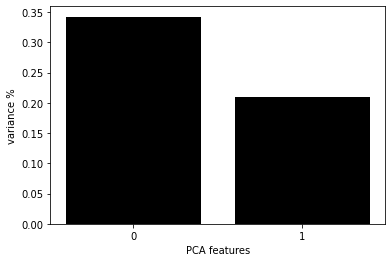

In [317]:
# Create a PCA instance: pca
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df3)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

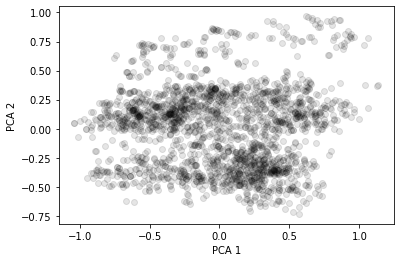

In [318]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

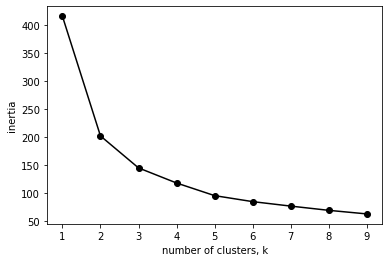

In [176]:
# k-means clustering algorithm WITH PCA COMPONENTS
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

model = KMeans(n_clusters=2)
label = model.fit_predict(PCA_components.iloc[:,:3])

In [302]:
# DBSCAN CLUSTERING ALGORITHM WITH PCA COMPONENTS
DBSCAN_cluster = DBSCAN(eps=1, min_samples=10).fit(PCA_components.iloc[:,:2])

label = DBSCAN_cluster.labels_

In [319]:
# AGGLOMERATIVE - WARD HIERARCHICAL CLUSTERING WITH PCA COMPONENTS
cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
label = cluster.fit_predict(PCA_components.iloc[:,:2])

In [179]:
# BIRCH CLUSTERING WITH PCA COMPONENTS

bclust=Birch(branching_factor=300, n_clusters = 2, threshold=.5).fit(PCA_components.iloc[:,:3])

label = bclust.predict(PCA_components.iloc[:,:3])

In [102]:
# SPECTRAL CLUSTERING WITH PCA COMPONENTS

spectral_cluster_model= SpectralClustering(
    n_clusters=2, 
    random_state=25, 
    n_neighbors=5, 
    affinity='nearest_neighbors'
)

label = spectral_cluster_model.fit_predict(PCA_components.iloc[:,:5])

In [29]:
# Neural network with keras
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import keras
from tensorflow.keras.losses import categorical_crossentropy

# Divide data into features X and target (Classes) Y
X = df.iloc[:,:18]
Y = df.iloc[:,18]

print(X.shape)
print(Y.shape)

# Check for class imbalance
print(df.groupby(Y).size())

# For Keras, convert dataframe to array values (Inbuilt requirement of Keras)
X = X.values
Y = Y.values

# First define baseline model. Then use it in Keras Classifier for the training
# Create model here
model = Sequential()
model.add(Dense(150, input_dim = 18, activation = 'relu')) # Rectified Linear Unit Activation Function
model.add(Dense(150, activation = 'relu'))
model.add(Dense(150, activation = 'relu'))
model.add(Dense(150, activation = 'relu'))
model.add(Dense(11, activation = 'softmax')) # Softmax for multi-class classification
# Compile model here
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(), # default from_logits=False
              optimizer = 'adam', metrics=[keras.metrics.SparseCategoricalAccuracy()])

# Random seed for reproducibility
seed = 10
np.random.seed(seed)

# KFold Cross Validation
kfold = KFold(n_splits = 5, shuffle = True, random_state = seed)
# Try different values of splits e.g., 10


(2126, 18)
(2126,)
CLASS
1.0     384
2.0     579
3.0      53
4.0      81
5.0      72
6.0     332
7.0     252
8.0     107
9.0      69
10.0    197
dtype: int64


In [30]:
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

model.fit(
    x=X_train,
    y=Y_train,
    batch_size=150,
    epochs=100,
    verbose=1,
    validation_split=0.2,
    shuffle=True,
    steps_per_epoch=None,
    workers=1,
    use_multiprocessing=False,
)
    
Y_pred = model.predict(
    X_test,
    batch_size=None,
    verbose=0,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

y_pred = np.argmax(Y_pred, axis=1)
y_true = Y_test

Epoch 1/100
10/10 [==============================] - 1s 24ms/step - loss: 2.2524 - sparse_categorical_accuracy: 0.3471 - val_loss: 1.9626 - val_sparse_categorical_accuracy: 0.4721
Epoch 2/100
10/10 [==============================] - 0s 9ms/step - loss: 1.7361 - sparse_categorical_accuracy: 0.4838 - val_loss: 1.7614 - val_sparse_categorical_accuracy: 0.6598
Epoch 3/100
10/10 [==============================] - 0s 10ms/step - loss: 1.3114 - sparse_categorical_accuracy: 0.6301 - val_loss: 1.7141 - val_sparse_categorical_accuracy: 0.7155
Epoch 4/100
10/10 [==============================] - 0s 11ms/step - loss: 1.0492 - sparse_categorical_accuracy: 0.6640 - val_loss: 1.4966 - val_sparse_categorical_accuracy: 0.6657
Epoch 5/100
10/10 [==============================] - 0s 10ms/step - loss: 0.8487 - sparse_categorical_accuracy: 0.7066 - val_loss: 1.3654 - val_sparse_categorical_accuracy: 0.6393
Epoch 6/100
10/10 [==============================] - 0s 11ms/step - loss: 0.8038 - sparse_categorical

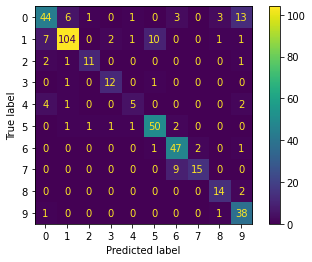

In [31]:
# Confusion Matrix for the classification task
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [32]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         1.0       0.76      0.62      0.68        71
         2.0       0.91      0.83      0.87       126
         3.0       0.85      0.73      0.79        15
         4.0       0.80      0.86      0.83        14
         5.0       0.62      0.42      0.50        12
         6.0       0.81      0.89      0.85        56
         7.0       0.77      0.92      0.84        51
         8.0       0.88      0.62      0.73        24
         9.0       0.74      0.88      0.80        16
        10.0       0.66      0.95      0.78        40

    accuracy                           0.80       425
   macro avg       0.78      0.77      0.77       425
weighted avg       0.81      0.80      0.80       425

